<a href="https://colab.research.google.com/github/CD-AC/DataEnginner-Gas_Station_Geolocation/blob/main/Dataset_Station.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

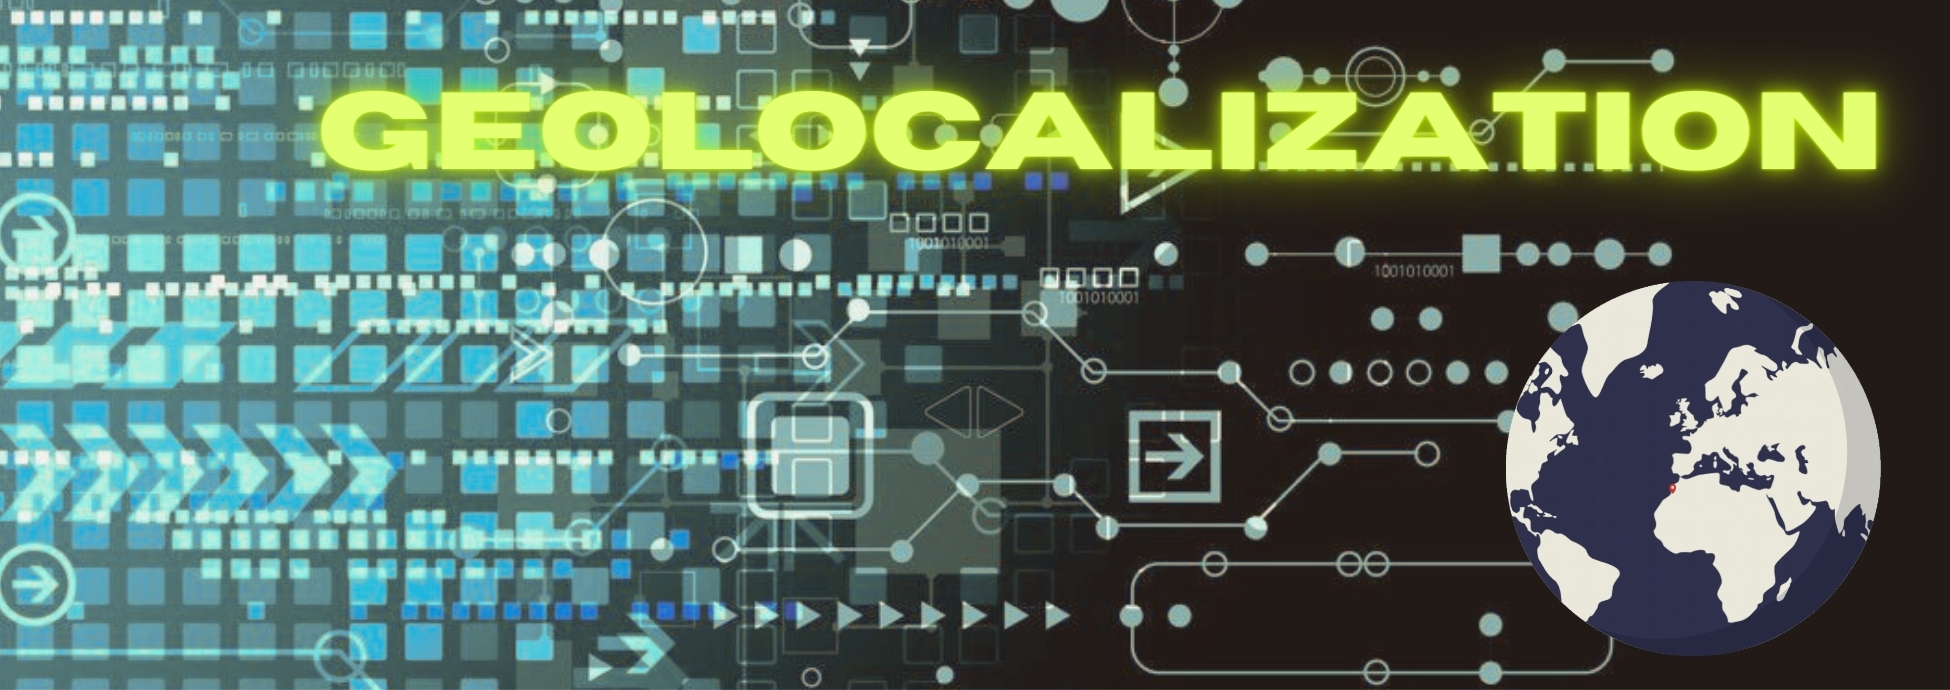

In [1]:
import requests
import random
import pandas as pd
from tqdm import tqdm
from bs4  import BeautifulSoup
from cred_here import YOUR_API_KEY
import json
from tqdm import tqdm
import time

import ast

In [2]:
YOUR_API_KEY = YOUR_API_KEY

In [25]:
df = pd.read_csv('Dataset_Station.csv')

In [26]:
df.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA CORRIENTE OXIGENADA,9860,A
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,BIODIESEL EXTRA,9780,A


# Clean Data

In [27]:
df[df['Periodo']==2022]['Mes'].max()

2

In [28]:
df2 =  df[(df['Periodo']==2022) & (df['Mes']==2)]
df2 =  df2[(df2['Departamento']=='BOGOTA D.C.')]

In [29]:
df2['Municipio'].value_counts().head(10)

BOGOTA  D.C.    857
Name: Municipio, dtype: int64

In [30]:
df3 = df2[(df2['Departamento']=='BOGOTA D.C.')]
df3.reset_index(inplace = True)
df3.drop(columns = 'index',inplace = True)

In [31]:
df3.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA CORRIENTE OXIGENADA,9860,A
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,BIODIESEL EXTRA,9780,A


In [32]:
df3['Municipio'].unique()

array(['BOGOTA  D.C.'], dtype=object)

In [33]:
df3['Dir2'] = df3['Direccion'].apply(lambda x : x.replace('#','No'))
df3['Full_Address'] = df3.apply(lambda x : x['Direccion'] + ', ' + x['Municipio'].capitalize() + ', Colombia' , axis = 1)

In [34]:
df3['Full_Address'].nunique()

239

In [35]:
df3['Full_Address'][0]

'AVENIDA CARRERA 7 No. 123A-48, Bogota  d.c., Colombia'

In [36]:
estaciones =  df3[['Nombre_comercial','Direccion','Full_Address']].drop_duplicates(subset = 'Nombre_comercial')
estaciones.reset_index(inplace = True)
estaciones.drop(columns = 'index',inplace = True)

In [54]:
estaciones['Full_Address'][1]

'Carrera 24  No 7-11, Bogota  d.c., Colombia'

In [55]:
address = estaciones['Full_Address'][1]
url = f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={YOUR_API_KEY}'
response = requests.get(url).json()

In [61]:
def GetLatLon2_google(Address,YOUR_API_KEY):

    api_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={Address}&key={YOUR_API_KEY}'
    try:
        j = requests.get(api_url).json()
        CleanAddress = str(j['results'][0]['formatted_address']).upper()
        LAT = j['results'][0]['geometry']['location']['lat']
        LON = j['results'][0]['geometry']['location']['lng']
        results = [CleanAddress,round(LAT,7),round(LON,7)]
    except:
        results = ['NotFound','NA','NA']
    return results

In [62]:
GetLatLon2_google(address,YOUR_API_KEY)

['KR 24 #7-11, BOGOTÁ, COLOMBIA', 4.6043147, -74.0925892]

# Extracción de coordenadas

In [63]:
coordenadas = []
tiempo = [1,2,2.5]

for i in tqdm(range(len(estaciones['Full_Address'])),colour = 'green'):

    try :

        R = GetLatLon2_google(estaciones['Full_Address'][i],YOUR_API_KEY)
        geo_source = R[1],R[2]
        coordenadas.append(geo_source)

    except :

        coordenadas.append('Error')


    time.sleep(random.choices(tiempo)[0])



100%|██████████| 239/239 [08:01<00:00,  2.01s/it]


In [64]:
estaciones['Coords'] = coordenadas

In [65]:
len(estaciones)

239

In [66]:
estaciones.head(200)

,Nombre_comercial,Direccion,Full_Address,Coords
0,SUPER ESTACION DE SERVICIO TEXACO 10,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)"
1,ESTACION DE SERVICIO ROXI,Carrera 24 No 7-11,"Carrera 24 No 7-11, Bogota d.c., Colombia","(4.6043147, -74.0925892)"
2,SERVICENTRO ESSO SANTA ISABEL,Avenida Carrera 30 # 2 - 38,"Avenida Carrera 30 # 2 - 38, Bogota d.c., Col...","(NA, NA)"
3,ESTACIÓN DE SERVICIO COMBUSCOL - OCCIDENTE,Carrera 96H N. 17 - 25,"Carrera 96H N. 17 - 25, Bogota d.c., Colombia","(4.6705307, -74.1427419)"
4,TEXACO 38 ESTACIÓN DE SERVICIO CALLE 50,CRA 17 # 50-42,"CRA 17 # 50-42, Bogota d.c., Colombia","(NA, NA)"
...,...,...,...,...
195,ESTACION DE SERVICIO COUNTRY CLUB DE BOGOTA,CLL 127 C N 15 - 02,"CLL 127 C N 15 - 02, Bogota d.c., Colombia","(4.7039665, -74.042854)"
196,BIOMAX INVERNIZA,TRANSVERSAL 73A No. 82H-55,"TRANSVERSAL 73A No. 82H-55, Bogota d.c., Colo...","(4.704507, -74.0901866)"
197,COMBUSTIBLES VENECIA SAS No 1,AVENIDA CARRERA 68 No. 43-67 SUR,"AVENIDA CARRERA 68 No. 43-67 SUR, Bogota d.c....","(4.6558451, -74.101767)"
198,EDS TOROGAS SOSIEGO,CRA 10 No. 27-05 SUR,"CRA 10 No. 27-05 SUR, Bogota d.c., Colombia","(4.6137888, -74.0700844)"


In [67]:
df_final = pd.merge(df3,estaciones[['Full_Address','Coords']],how = 'inner' , on = 'Full_Address')

In [68]:
df_final.head(3)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Dir2,Full_Address,Coords
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA CORRIENTE OXIGENADA,9860,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)"
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,BIODIESEL EXTRA,9780,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)"
2,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA EXTRA OXIGENADA,17250,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)"


In [69]:
df_final = pd.merge(df3,estaciones[['Full_Address','Coords']],how = 'inner' , on = 'Full_Address')

In [70]:
df_final.to_csv('DATASET_FINAL.CSV',index = False)